In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.preprocessing import maxabs_scale
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.model_selection import train_test_split

from collections import deque

%matplotlib inline

In [216]:
# random state
rs = 2

# Data

Gathering and preparation of the data to be inputed into the model.

The countries were selected in the EDA file, populations were taken from https://worldpopulationreview.com/countries.

In [217]:
# Spain, UK, Italy, Germany...
cc_dict = {
    'ARG': 'Argentina', 'AUS': 'Australia',  
    'CHN': 'China',     'CZE': 'Czechia',    
    'EGY': 'Egypt',     'FIN': 'Finland',
    'HND': 'Honduras',  'IND': 'India',
    'JPN': 'Japan',     'NOR': 'Norway',
    'RUS': 'Russia',    'SWE': 'Sweden',
    'THA': 'Thailand',  'USA': 'US'
}

# cc_dict = {
#     'BEL': 'Belgium',      'CMR': 'Cameroon',    'DOM': 'Dominican Republic',
#     'EGY': 'Egypt',        'IRQ': 'Iraq',        'JOR': 'Jordan',
#     'MLI': 'Mali',         'MWI': 'Malawi',      'NLD': 'Netherlands',
#     'POL': 'Poland',       'SSD': 'South Sudan', 'TUN': 'Tunisia',
#     'ZAF': 'South Africa', 'ZMB': 'Zambia',      'ZWE': 'Zimbabwe'
# }

pop_dict = { # 2020 population
    'ARG': 45195774,   'AUS': 25499884, 
    'CHN': 1439323776, 'CZE': 10708981,   
    'EGY': 102334404,  'FIN': 5540720,  
    'HND': 9904607,    'IND': 1380004385, 
    'JPN': 126476461,  'NOR': 5421241,  
    'RUS': 145934462,  'SWE': 10099265,
    'THA': 69799978,   'USA': 331002651
}

# pop_dict = {
#     'BEL': 11589623,  'CMR': 26545863, 'DOM': 10847910,
#     'EGY': 102334404, 'IRQ': 40222493, 'JOR': 10203134,
#     'MLI': 20250833,  'MWI': 19129952, 'NLD': 17134872,
#     'POL': 37846611,  'SSD': 11193725, 'TUN': 11818619,
#     'ZAF': 59308690,  'ZMB': 18383955, 'ZWE': 14862924
# }

# pd.read_html('https://worldpopulationreview.com/countries', header=0, index_col=1)[0].reindex(cc_dict.values())

## Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

In [218]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [219]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(279, 615)

In [220]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(279, 615)

In [221]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(264, 615)

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [222]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,152,169,191,207,219,226,245,261,291,300,314,335,361,374,386,398,421,433,451,483,498,509,528,548,563,587,602,617,630,652,665,680,710,725,742,749,765,782,798,817
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,13978,14416,15043,15717,16353,17173,17995,18800,19545,20466,21471,22346,23372,24585,25857,27026,28111,29390,30807,32323,33792,35064,36267,37724,39108,40616,42219,43436,44674,45782,47007,48341,49611,50919,51986,52922,53898,54919,55962,56988
10,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,200,200,200,200,200,200,200,200,200,200,200,201,201,202,201,202,202,202,202,202,202,202,203,203,203,203,203,203,203,203,203,204,204,204,204,206,206,206,208,208
11,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,...,1955,1957,1961,1961,1962,1964,1964,1966,1972,1972,1972,1973,1977,1977,1979,1979,1980,1982,1982,1984,1985,1991,1991,1991,1992,1995,2002,2003,2007,2009,2010,2013,2014,2015,2015,2017,2018,2019,2021,2021
12,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,868,868,868,868,869,869,869,869,870,870,870,870,870,871,871,871,871,871,875,877,879,880,881,888,889,891,891,892,894,895,896,896,898,898,898,898,898,898,899,900
13,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235
14,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,...,21166,21191,21215,21271,21328,21389,21455,21526,21577,21618,21694,21772,21835,21926,21996,22071,22187,22361,22570,22759,22942,23188,23429,23641,23964,24297,24747,25128,25591,26036,26439,26942,27439,27968,28456,29008,29596,30216,30961,31679
15,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1061,1061,1061,1062,1062,1063,1063,1063,1064,1064,1084,1084,1084,1086,1086,1086,1086,1086,1086,1086,1086,1086,1087,1087,1088,1088,1088,1089,1089,1089,1089,1089,1089,1092,1092,1093,1094,1094,1094,1094


In [223]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21
193,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13350,13406,13511,13511,13719,13871,13948,14003,14060,14153,14231,14318,14374,14429,14465,14508,14576,14662,14719,14764,14812,14812,14861,14913,14955,14991,15022,15057,15076,15092,15129,15155,15177,15202,15221,15249,15274,15305,15305,15351
194,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1754,1756,1756,1759,1765,1767,1768,1774,1776,1779,1780,1783,1785,1786,1787,1791,1791,1793,1800,1808,1819,1837,1850,1863,1885,1895,1908,1928,1932,1932,1945,1949,1956,1962,1969,1972,1974,1980,1988,1998
195,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14570,14602,14686,14751,14802,14889,14889,14937,14974,15045,15086,15134,15170,15216,15248,15263,15299,15338,15379,15413,15452,15470,15483,15506,15550,15596,15642,15696,15713,15741,15814,15867,15925,15975,16031,16056,16086,16150,16216,16254
196,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3185,3185,3227,3313,3366,3394,3394,3394,3394,3472,3520,3580,3580,3616,3641,3679,3719,3746,3775,3797,3824,3824,3849,3888,3921,3947,3947,3969,3979,3999,4021,4021,4053,4070,4070,4091,4117,4146,4161,4178
197,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1901900,1904128,1906434,1909211,1911699,1913908,1916316,1918769,1921159,1923596,1926424,1929018,1931833,1934283,1936572,1938743,1941055,1943882,1946655,1949195,1951886,1954233,1956348,1958804,1961585,1963947,1966634,1968832,1968832,1972653,1974662,1977016,1979114,1981252,1983252,1984915,1986241,1987905,1989805,1991628


Canada does not have recovery data available at province-level.

In [224]:
jhu_cases['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Ecuador            1
Name: Country/Region, dtype: int64

In [225]:
jhu_death['Country/Region'].value_counts().head(9)

China             34
Canada            16
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Ecuador            1
Name: Country/Region, dtype: int64

In [226]:
jhu_recov['Country/Region'].value_counts().head(9)

China             34
United Kingdom    12
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Ecuador            1
Uruguay            1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [227]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (275, 612)
deaths shape: (275, 612)
recoveries shape: (260, 612)


In [228]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (611, 195)
deaths shape: (611, 195)
recoveries shape: (611, 195)


Create separate dataframes containing data on countries of interest only. Apply a smoothing average to the curves. Use them to compute further variables needed for the model.

In [229]:
window = 5

In [230]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.00,703.666667,0.0,0.0,0.0,0.000000,0.000000e+00,2.000000e+00,0.00,0.000000e+00,0.000000e+00,4.333333e+00,1.333333e+00
2020-01-23,0.000000e+00,0.00,879.250000,0.0,0.0,0.0,0.000000,0.000000e+00,2.000000e+00,0.00,0.000000e+00,0.000000e+00,4.750000e+00,1.500000e+00
2020-01-24,0.000000e+00,0.80,1118.400000,0.0,0.0,0.0,0.000000,0.000000e+00,2.400000e+00,0.00,0.000000e+00,0.000000e+00,5.400000e+00,2.200000e+00
2020-01-25,0.000000e+00,1.80,1584.200000,0.0,0.0,0.0,0.000000,0.000000e+00,2.800000e+00,0.00,0.000000e+00,0.000000e+00,6.200000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.80,2557.400000,0.0,0.0,0.0,0.000000,0.000000e+00,3.800000e+00,0.00,0.000000e+00,0.000000e+00,8.200000e+00,3.800000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,5.239925e+06,87178.20,107965.200000,1686142.0,296949.6,136330.4,358476.200000,3.347600e+07,1.677035e+06,182303.80,7.169649e+06,1.145379e+06,1.475492e+06,4.216660e+07
2021-09-20,5.241546e+06,88802.60,108022.400000,1686544.6,297619.4,136686.2,359440.200000,3.350521e+07,1.680104e+06,182986.60,7.189110e+06,1.145959e+06,1.488005e+06,4.227655e+07
2021-09-21,5.243224e+06,90465.40,108076.600000,1686963.6,298306.2,137058.6,360214.800000,3.353454e+07,1.682953e+06,183699.60,7.208775e+06,1.146690e+06,1.500348e+06,4.240087e+07
2021-09-22,5.244222e+06,91299.75,108105.500000,1687159.0,298650.5,137259.0,360855.000000,3.354856e+07,1.684168e+06,184064.75,7.218452e+06,1.147118e+06,1.506315e+06,4.247904e+07


In [231]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,20.333333,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.0
2020-01-23,0.000000,0.000000,25.750000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.0
2020-01-24,0.000000,0.000000,31.800000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.0
2020-01-25,0.000000,0.000000,44.800000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.0
2020-01-26,0.000000,0.000000,67.400000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,114435.600000,1168.200000,4849.000000,30431.800000,16972.800000,1055.4,9506.4,445130.60,17213.600000,841.0,194669.200000,14778.00,15362.800000,674872.8
2021-09-20,114515.200000,1177.800000,4849.000000,30435.600000,16994.400000,1057.4,9541.4,445434.80,17259.200000,842.8,195453.400000,14784.80,15488.600000,676584.2
2021-09-21,114596.200000,1187.000000,4849.000000,30439.400000,17019.000000,1059.4,9568.6,445740.80,17302.000000,844.6,196242.000000,14792.40,15616.200000,678759.6
2021-09-22,114638.250000,1192.000000,4849.000000,30441.750000,17031.250000,1060.0,9588.0,445892.75,17321.500000,845.5,196634.750000,14796.75,15679.500000,680006.0


In [232]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.0,0.0,31.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333333,0.0
2020-01-23,0.0,0.0,33.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.500000,0.0
2020-01-24,0.0,0.0,36.400000,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,3.200000,0.0
2020-01-25,0.0,0.0,42.400000,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,4.000000,0.0
2020-01-26,0.0,0.0,56.600000,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,4.800000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-09-20,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-09-21,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2021-09-22,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [233]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [234]:
R = cum_deaths + cum_recoveries
R

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,51.666667,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,2.333333,0.0
2020-01-23,0.000000,0.000000,59.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,2.500000,0.0
2020-01-24,0.000000,0.000000,68.200000,0.000000,0.000000,0.0,0.0,0.00,0.200000,0.0,0.000000,0.00,3.200000,0.0
2020-01-25,0.000000,0.000000,87.200000,0.000000,0.000000,0.0,0.0,0.00,0.400000,0.0,0.000000,0.00,4.000000,0.0
2020-01-26,0.000000,0.000000,124.000000,0.000000,0.000000,0.0,0.0,0.00,0.600000,0.0,0.000000,0.00,4.800000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,114435.600000,1168.200000,4849.000000,30431.800000,16972.800000,1055.4,9506.4,445130.60,17213.600000,841.0,194669.200000,14778.00,15362.800000,674872.8
2021-09-20,114515.200000,1177.800000,4849.000000,30435.600000,16994.400000,1057.4,9541.4,445434.80,17259.200000,842.8,195453.400000,14784.80,15488.600000,676584.2
2021-09-21,114596.200000,1187.000000,4849.000000,30439.400000,17019.000000,1059.4,9568.6,445740.80,17302.000000,844.6,196242.000000,14792.40,15616.200000,678759.6
2021-09-22,114638.250000,1192.000000,4849.000000,30441.750000,17031.250000,1060.0,9588.0,445892.75,17321.500000,845.5,196634.750000,14796.75,15679.500000,680006.0


In [235]:
I = cum_cases - R
I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000,652.00,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.000000e+00,0.00,0.0,0.000000e+00,2.000000e+00,1.333333e+00
2020-01-23,0.000000e+00,0.000000,820.25,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.000000e+00,0.00,0.0,0.000000e+00,2.250000e+00,1.500000e+00
2020-01-24,0.000000e+00,0.800000,1050.20,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.200000e+00,0.00,0.0,0.000000e+00,2.200000e+00,2.200000e+00
2020-01-25,0.000000e+00,1.800000,1497.00,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,2.400000e+00,0.00,0.0,0.000000e+00,2.200000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.800000,2433.40,0.000000e+00,0.000000,0.0,0.000000,0.000000e+00,3.200000e+00,0.00,0.0,0.000000e+00,3.400000e+00,3.800000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,5.125490e+06,86010.000000,103116.20,1.655710e+06,279976.800000,135275.0,348969.800000,3.303087e+07,1.659821e+06,181462.80,6974979.6,1.130601e+06,1.460129e+06,4.149173e+07
2021-09-20,5.127031e+06,87624.800000,103173.40,1.656109e+06,280625.000000,135628.8,349898.800000,3.305977e+07,1.662844e+06,182143.80,6993656.2,1.131174e+06,1.472517e+06,4.159996e+07
2021-09-21,5.128628e+06,89278.400000,103227.60,1.656524e+06,281287.200000,135999.2,350646.200000,3.308879e+07,1.665651e+06,182855.00,7012533.2,1.131898e+06,1.484731e+06,4.172211e+07
2021-09-22,5.129584e+06,90107.750000,103256.50,1.656717e+06,281619.250000,136199.0,351267.000000,3.310267e+07,1.666846e+06,183219.25,7021817.0,1.132321e+06,1.490636e+06,4.179904e+07


In [236]:
S = pop_dict.values() - cum_cases
S

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,4.519577e+07,25499884.00,1.439323e+09,10708981.0,102334404.0,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5421241.00,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-23,4.519577e+07,25499884.00,1.439323e+09,10708981.0,102334404.0,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5421241.00,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-24,4.519577e+07,25499883.20,1.439323e+09,10708981.0,102334404.0,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5421241.00,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-25,4.519577e+07,25499882.20,1.439322e+09,10708981.0,102334404.0,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5421241.00,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
2020-01-26,4.519577e+07,25499881.20,1.439321e+09,10708981.0,102334404.0,5540720.0,9.904607e+06,1.380004e+09,1.264765e+08,5421241.00,1.459345e+08,1.009926e+07,6.979997e+07,3.310026e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,3.995585e+07,25412705.80,1.439216e+09,9022839.0,102037454.4,5404389.6,9.546131e+06,1.346528e+09,1.247994e+08,5238937.20,1.387648e+08,8.953886e+06,6.832449e+07,2.888360e+08
2021-09-20,3.995423e+07,25411081.40,1.439216e+09,9022436.4,102036784.6,5404033.8,9.545167e+06,1.346499e+09,1.247964e+08,5238254.40,1.387454e+08,8.953306e+06,6.831197e+07,2.887261e+08
2021-09-21,3.995255e+07,25409418.60,1.439216e+09,9022017.4,102036097.8,5403661.4,9.544392e+06,1.346470e+09,1.247935e+08,5237541.40,1.387257e+08,8.952575e+06,6.829963e+07,2.886018e+08
2021-09-22,3.995155e+07,25408584.25,1.439216e+09,9021822.0,102035753.5,5403461.0,9.543752e+06,1.346456e+09,1.247923e+08,5237176.25,1.387160e+08,8.952148e+06,6.829366e+07,2.885236e+08


### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $g^*=\log{i_2}-\log{i_1}=\beta^*-\gamma^*$.

In [237]:
i_prop = I / pop_dict.values()
i_prop

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000e+00,4.529905e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.581322e-08,0.000000,0.000000,0.000000,2.865330e-08,4.028165e-09
2020-01-23,0.000000,0.000000e+00,5.698857e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.581322e-08,0.000000,0.000000,0.000000,3.223497e-08,4.531686e-09
2020-01-24,0.000000,3.137269e-08,7.296482e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.739454e-08,0.000000,0.000000,0.000000,3.151863e-08,6.646472e-09
2020-01-25,0.000000,7.058856e-08,1.040072e-06,0.000000,0.000000,0.000000,0.000000,0.000000,1.897586e-08,0.000000,0.000000,0.000000,3.151863e-08,9.063372e-09
2020-01-26,0.000000,1.098044e-07,1.690655e-06,0.000000,0.000000,0.000000,0.000000,0.000000,2.530115e-08,0.000000,0.000000,0.000000,4.871062e-08,1.148027e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,0.113406,3.372957e-03,7.164212e-05,0.154610,0.002736,0.024415,0.035233,0.023935,1.312356e-02,0.033473,0.047795,0.111949,2.091877e-02,1.253517e-01
2021-09-20,0.113440,3.436282e-03,7.168186e-05,0.154647,0.002742,0.024479,0.035327,0.023956,1.314746e-02,0.033598,0.047923,0.112006,2.109623e-02,1.256786e-01
2021-09-21,0.113476,3.501130e-03,7.171951e-05,0.154686,0.002749,0.024545,0.035402,0.023977,1.316965e-02,0.033729,0.048053,0.112077,2.127123e-02,1.260477e-01
2021-09-22,0.113497,3.533653e-03,7.173959e-05,0.154704,0.002752,0.024581,0.035465,0.023987,1.317910e-02,0.033797,0.048116,0.112119,2.135582e-02,1.262801e-01


In [238]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,-14.607395,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.367997,-19.329955
2020-01-23,0.000000,0.000000,-14.377830,0.000000,0.000000,0.000000,0.000000,0.000000,-17.962420,0.000000,0.000000,0.000000,-17.250214,-19.212172
2020-01-24,0.000000,-17.277328,-14.130703,0.000000,0.000000,0.000000,0.000000,0.000000,-17.867109,0.000000,0.000000,0.000000,-17.272687,-18.829180
2020-01-25,0.000000,-16.466398,-13.776221,0.000000,0.000000,0.000000,0.000000,0.000000,-17.780098,0.000000,0.000000,0.000000,-17.272687,-18.519025
2020-01-26,0.000000,-16.024565,-13.290395,0.000000,0.000000,0.000000,0.000000,0.000000,-17.492416,0.000000,0.000000,0.000000,-16.837369,-18.282636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,-2.176778,-5.691966,-9.543827,-1.866853,-5.901294,-3.712570,-3.345770,-3.732399,-4.333346,-3.397029,-3.040828,-2.189713,-3.867109,-2.076632
2021-09-20,-2.176477,-5.673365,-9.543273,-1.866612,-5.898982,-3.709958,-3.343111,-3.731525,-4.331527,-3.393284,-3.038154,-2.189207,-3.858661,-2.074027
2021-09-21,-2.176165,-5.654670,-9.542748,-1.866361,-5.896625,-3.707231,-3.340978,-3.730647,-4.329840,-3.389387,-3.035459,-2.188567,-3.850400,-2.071095
2021-09-22,-2.175979,-5.645423,-9.542468,-1.866245,-5.895445,-3.705763,-3.339209,-3.730228,-4.329123,-3.387397,-3.034136,-2.188193,-3.846431,-2.069253


In [239]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117783,0.117783
2020-01-24,0.000000,-17.277328,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-25,0.000000,0.810930,0.354482,0.000000,0.000000,0.000000,0.000000,0.000000,0.087011,0.000000,0.000000,0.000000,0.000000,0.310155
2020-01-26,0.000000,0.441833,0.485826,0.000000,0.000000,0.000000,0.000000,0.000000,0.287682,0.000000,0.000000,0.000000,0.435318,0.236389
2020-01-27,0.000000,0.356675,0.342863,0.000000,0.000000,-17.137073,0.000000,0.000000,0.223144,0.000000,0.000000,0.000000,0.302281,0.191055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,0.000308,0.019072,0.000565,0.000236,0.002253,0.002659,0.003138,0.000898,0.002175,0.003279,0.002690,0.000523,0.008972,0.002976
2021-09-20,0.000301,0.018600,0.000555,0.000241,0.002313,0.002612,0.002659,0.000875,0.001820,0.003746,0.002674,0.000506,0.008448,0.002605
2021-09-21,0.000311,0.018696,0.000525,0.000251,0.002357,0.002727,0.002134,0.000877,0.001686,0.003897,0.002696,0.000640,0.008261,0.002932
2021-09-22,0.000186,0.009247,0.000280,0.000117,0.001180,0.001468,0.001769,0.000419,0.000718,0.001990,0.001323,0.000373,0.003969,0.001842


### Transmission coefficient computation

Operate with the absolute compartments; $S, I, R$. This is, with the number of people in each compartment. Only assuming independence with time (same as last time), study $\beta=\frac{g+\gamma}{S}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [240]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_I = np.log(I)
warnings.resetwarnings()
# before the pandemic begins
log_I[np.isinf(log_I)] = 0
log_I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,6.480045,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.287682
2020-01-23,0.000000,0.000000,6.709609,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.810930,0.405465
2020-01-24,0.000000,-0.223144,6.956736,0.000000,0.000000,0.000000,0.000000,0.000000,0.788457,0.000000,0.000000,0.000000,0.788457,0.788457
2020-01-25,0.000000,0.587787,7.311218,0.000000,0.000000,0.000000,0.000000,0.000000,0.875469,0.000000,0.000000,0.000000,0.788457,1.098612
2020-01-26,0.000000,1.029619,7.797045,0.000000,0.000000,0.000000,0.000000,0.000000,1.163151,0.000000,0.000000,0.000000,1.223775,1.335001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,15.449737,11.362219,11.543612,14.319741,12.542462,11.815065,12.762741,17.312953,14.322221,12.108806,15.757840,13.938260,14.194036,17.541005
2021-09-20,15.450037,11.380819,11.544166,14.319981,12.544775,11.817677,12.765399,17.313828,14.324040,12.112552,15.760514,13.938766,14.202483,17.543610
2021-09-21,15.450349,11.399515,11.544692,14.320232,12.547131,11.820404,12.767533,17.314705,14.325726,12.116449,15.763210,13.939406,14.210744,17.546542
2021-09-22,15.450535,11.408761,11.544971,14.320349,12.548311,11.821872,12.769302,17.315125,14.326444,12.118439,15.764533,13.939780,14.214713,17.548384


In [241]:
log_diff = log_I[1:] - log_I[:-1].values # different index
log_diff

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117783,0.117783
2020-01-24,0.000000,-0.223144,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-25,0.000000,0.810930,0.354482,0.000000,0.000000,0.000000,0.000000,0.000000,0.087011,0.000000,0.000000,0.000000,0.000000,0.310155
2020-01-26,0.000000,0.441833,0.485826,0.000000,0.000000,0.000000,0.000000,0.000000,0.287682,0.000000,0.000000,0.000000,0.435318,0.236389
2020-01-27,0.000000,0.356675,0.342863,0.000000,0.000000,-1.609438,0.000000,0.000000,0.223144,0.000000,0.000000,0.000000,0.302281,0.191055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,0.000308,0.019072,0.000565,0.000236,0.002253,0.002659,0.003138,0.000898,0.002175,0.003279,0.002690,0.000523,0.008972,0.002976
2021-09-20,0.000301,0.018600,0.000555,0.000241,0.002313,0.002612,0.002659,0.000875,0.001820,0.003746,0.002674,0.000506,0.008448,0.002605
2021-09-21,0.000311,0.018696,0.000525,0.000251,0.002357,0.002727,0.002134,0.000877,0.001686,0.003897,0.002696,0.000640,0.008261,0.002932
2021-09-22,0.000186,0.009247,0.000280,0.000117,0.001180,0.001468,0.001769,0.000419,0.000718,0.001990,0.001323,0.000373,0.003969,0.001842


In [242]:
dR_dt = R[1:] - R[:-1].values # different index
dR_dt

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,7.333333,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00,0.166667,0.0
2020-01-24,0.000000,0.000000,9.200000,0.000000,0.000000,0.0,0.0,0.00,0.200000,0.0,0.000000,0.00,0.700000,0.0
2020-01-25,0.000000,0.000000,19.000000,0.000000,0.000000,0.0,0.0,0.00,0.200000,0.0,0.000000,0.00,0.800000,0.0
2020-01-26,0.000000,0.000000,36.800000,0.000000,0.000000,0.0,0.0,0.00,0.200000,0.0,0.000000,0.00,0.800000,0.0
2020-01-27,0.000000,0.000000,38.200000,0.000000,0.000000,0.0,0.0,0.00,0.200000,0.0,0.000000,0.00,0.600000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,95.600000,9.000000,0.000000,4.000000,19.000000,1.4,32.2,304.00,48.600000,0.0,779.000000,7.40,131.800000,1626.8
2021-09-20,79.600000,9.600000,0.000000,3.800000,21.600000,2.0,35.0,304.20,45.600000,1.8,784.200000,6.80,125.800000,1711.4
2021-09-21,81.000000,9.200000,0.000000,3.800000,24.600000,2.0,27.2,306.00,42.800000,1.8,788.600000,7.60,127.600000,2175.4
2021-09-22,42.050000,5.000000,0.000000,2.350000,12.250000,0.6,19.4,151.95,19.500000,0.9,392.750000,4.35,63.300000,1246.4


In [243]:
# to do: decide on infinite values
gamma = dR_dt / I[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,0.000000,0.008940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000
2020-01-24,0.000000,0.000000,0.008760,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.318182,0.000000
2020-01-25,0.000000,0.000000,0.012692,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.363636,0.000000
2020-01-26,0.000000,0.000000,0.015123,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.235294,0.000000
2020-01-27,0.000000,0.000000,0.011142,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.130435,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,0.000019,0.000105,0.000000,0.000002,0.000068,0.000010,0.000092,0.000009,0.000029,0.000000,0.000112,0.000007,0.000090,0.000039
2021-09-20,0.000016,0.000110,0.000000,0.000002,0.000077,0.000015,0.000100,0.000009,0.000027,0.000010,0.000112,0.000006,0.000085,0.000041
2021-09-21,0.000016,0.000103,0.000000,0.000002,0.000087,0.000015,0.000078,0.000009,0.000026,0.000010,0.000112,0.000007,0.000086,0.000052
2021-09-22,0.000008,0.000055,0.000000,0.000001,0.000043,0.000004,0.000055,0.000005,0.000012,0.000005,0.000056,0.000004,0.000042,0.000030


In [244]:
beta = (log_diff + gamma) / S[1:]
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000e+00,1.657064e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.748670e-09,3.558371e-10
2020-01-24,0.000000e+00,-8.750768e-09,1.777829e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.472363e-09,0.000000e+00,0.000000e+00,0.000000e+00,4.236520e-09,1.157067e-09
2020-01-25,0.000000e+00,3.180133e-08,2.551024e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.346849e-09,0.000000e+00,0.000000e+00,0.000000e+00,5.209692e-09,9.370165e-10
2020-01-26,0.000000e+00,1.732686e-08,3.480455e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.768753e-09,0.000000e+00,0.000000e+00,0.000000e+00,9.607629e-09,7.141598e-10
2020-01-27,0.000000e+00,1.398732e-08,2.459523e-10,0.000000e+00,0.000000e+00,-2.904745e-07,0.000000e+00,0.000000e+00,2.159640e-09,0.000000e+00,0.000000e+00,0.000000e+00,6.199368e-09,5.772015e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-19,8.185052e-12,7.545901e-10,3.922769e-13,2.637663e-11,2.274248e-11,4.938972e-10,3.384002e-10,6.737710e-13,1.765974e-11,6.258459e-10,2.019070e-11,5.918588e-11,1.326368e-10,1.044069e-11
2021-09-20,7.915348e-12,7.362950e-10,3.853211e-13,2.694715e-11,2.341790e-11,4.860712e-10,2.890063e-10,6.563826e-13,1.480049e-11,7.169742e-10,2.008145e-11,5.722349e-11,1.249163e-10,9.165372e-12
2021-09-21,8.188551e-12,7.398266e-10,3.649149e-13,2.803926e-11,2.395631e-11,5.074276e-10,2.316899e-10,6.585571e-13,1.371757e-11,7.459317e-10,2.024124e-11,7.223949e-11,1.222102e-10,1.033959e-11
2021-09-22,4.870275e-12,3.661002e-10,1.944981e-13,1.307395e-11,1.198862e-11,2.725019e-10,1.911312e-10,3.148195e-13,5.843861e-12,3.809202e-10,9.940771e-12,4.214181e-11,5.873592e-11,6.488016e-12


## Policy

We focus on policies aimed at obstructing the spread of the virus. The Oxford group considers four types of measures:

*   Containment
*   Economic
*   Health system
*   Miscellaneous

Here containment- and some health system-related measures are considered.

In [245]:
url_pol = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

oxcgrt = pd.read_csv(url_pol, dtype={'RegionName': str, 'RegionCode': str})

oxcgrt.drop(oxcgrt.columns[37:], axis=1, inplace=True)    # indexes and extra

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197496 entries, 0 to 197495
Data columns (total 37 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   CountryName                            197496 non-null  object        
 1   CountryCode                            197496 non-null  object        
 2   RegionName                             79758 non-null   object        
 3   RegionCode                             79758 non-null   object        
 4   Jurisdiction                           197496 non-null  object        
 5   Date                                   197496 non-null  datetime64[ns]
 6   C1_School closing                      191218 non-null  float64       
 7   C1_Flag                                156721 non-null  float64       
 8   C2_Workplace closing                   191096 non-null  float64       
 9   C2_Flag                                148803 no

Policy implementation is available at state level in some countries.

In [246]:
oxcgrt_sub = oxcgrt[oxcgrt['Jurisdiction'] == 'STATE_TOTAL'].copy()
oxcgrt_sub

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
14559,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14560,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14561,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14562,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
14563,Brazil,BRA,Acre,BR_AC,STATE_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191794,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191795,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191796,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-09-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191797,United States,USA,Wyoming,US_WY,STATE_TOTAL,2021-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
# region information
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True)

oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']
oxcgrt

,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people
0,Aruba,ABW,NAT_TOTAL,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
1,Aruba,ABW,NAT_TOTAL,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,Aruba,ABW,NAT_TOTAL,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
3,Aruba,ABW,NAT_TOTAL,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
4,Aruba,ABW,NAT_TOTAL,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197491,Zimbabwe,ZWE,NAT_TOTAL,2021-09-20,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,NaN,NaN,2.0,1.0,3.0,0.0,NaN,0.0,3.0,1.0,5.0,0.0,0.0
197492,Zimbabwe,ZWE,NAT_TOTAL,2021-09-21,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,NaN,NaN,2.0,1.0,3.0,0.0,NaN,0.0,3.0,1.0,5.0,0.0,0.0
197493,Zimbabwe,ZWE,NAT_TOTAL,2021-09-22,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,NaN,NaN,2.0,1.0,3.0,0.0,NaN,0.0,3.0,1.0,5.0,0.0,0.0
197494,Zimbabwe,ZWE,NAT_TOTAL,2021-09-23,1.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,0.0,NaN,0.0,NaN,NaN,2.0,1.0,3.0,0.0,NaN,0.0,3.0,1.0,5.0,0.0,0.0


The Oxford dataset contains earlier dates compared to the JHU dataset.

In [248]:
print('Virus data: ', jhu_cases.index.min(), '-', jhu_cases.index.max())
print('Policy data:', oxcgrt['Date'].min(), '-', oxcgrt['Date'].max())

Virus data:  2020-01-22 00:00:00 - 2021-09-23 00:00:00
Policy data: 2020-01-01 00:00:00 - 2021-09-24 00:00:00


Pivot the data to obtain a different dataset for each policy type indexed by time (date).

In [249]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

CH_X = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
 
idch

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'H1_Public information campaigns',
 'H6_Facial Coverings']

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

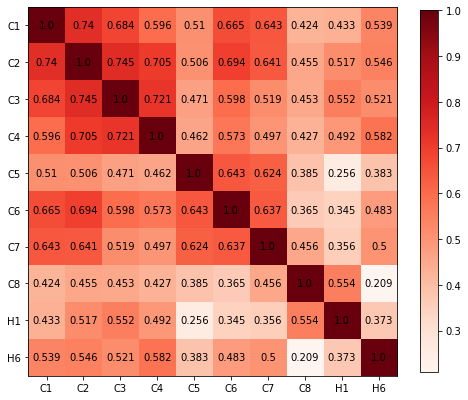

In [250]:
mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=corr, cmap='Reds') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# show all ticks...
ax.set_xticks(range(corr.shape[1]))
ax.set_yticks(range(corr.shape[0]))
# ...and label them
[s.split('_')[0] for s in idch]
ax.set_xticklabels([s.split('_')[0] for s in corr.columns])
ax.set_yticklabels([s.split('_')[0] for s in corr.index])
# loop over data dimensions and create text annotations
for i in range(corr.shape[1]):
  for j in range(corr.shape[0]):
    text = ax.text(j, i, round(corr.iloc[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [251]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 68
 - C2: 72
 - C3: 73
 - C4: 85
 - C5: 72
 - C6: 71
 - C7: 72
 - C8: 72
 - H1: 73
 - H6: 71


## Visualizations

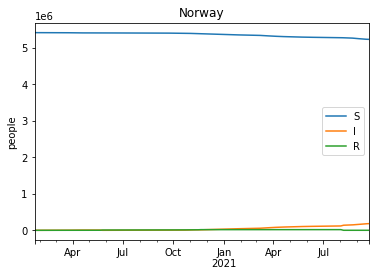

In [252]:
cc_idx = 9
country = list(cc_dict.values())[cc_idx]

S[country].plot()
I[country].plot()
R[country].plot()
plt.ylabel('people')
plt.title(country)
plt.legend(labels=['S', 'I', 'R'])
plt.show()

In [253]:
print('Missing values (NaN) in the response')
print(' - growth rate:', gr.isna().sum().sum())
print(' - transmission rate:', beta.isna().sum().sum())

Missing values (NaN) in the response
 - growth rate: 0
 - transmission rate: 0


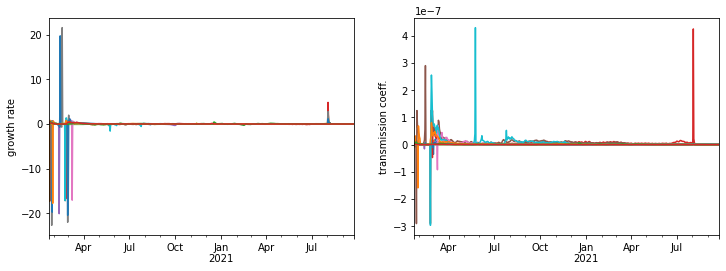

In [254]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
plt.show()

Most countries present spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low populated countries present various spikes.

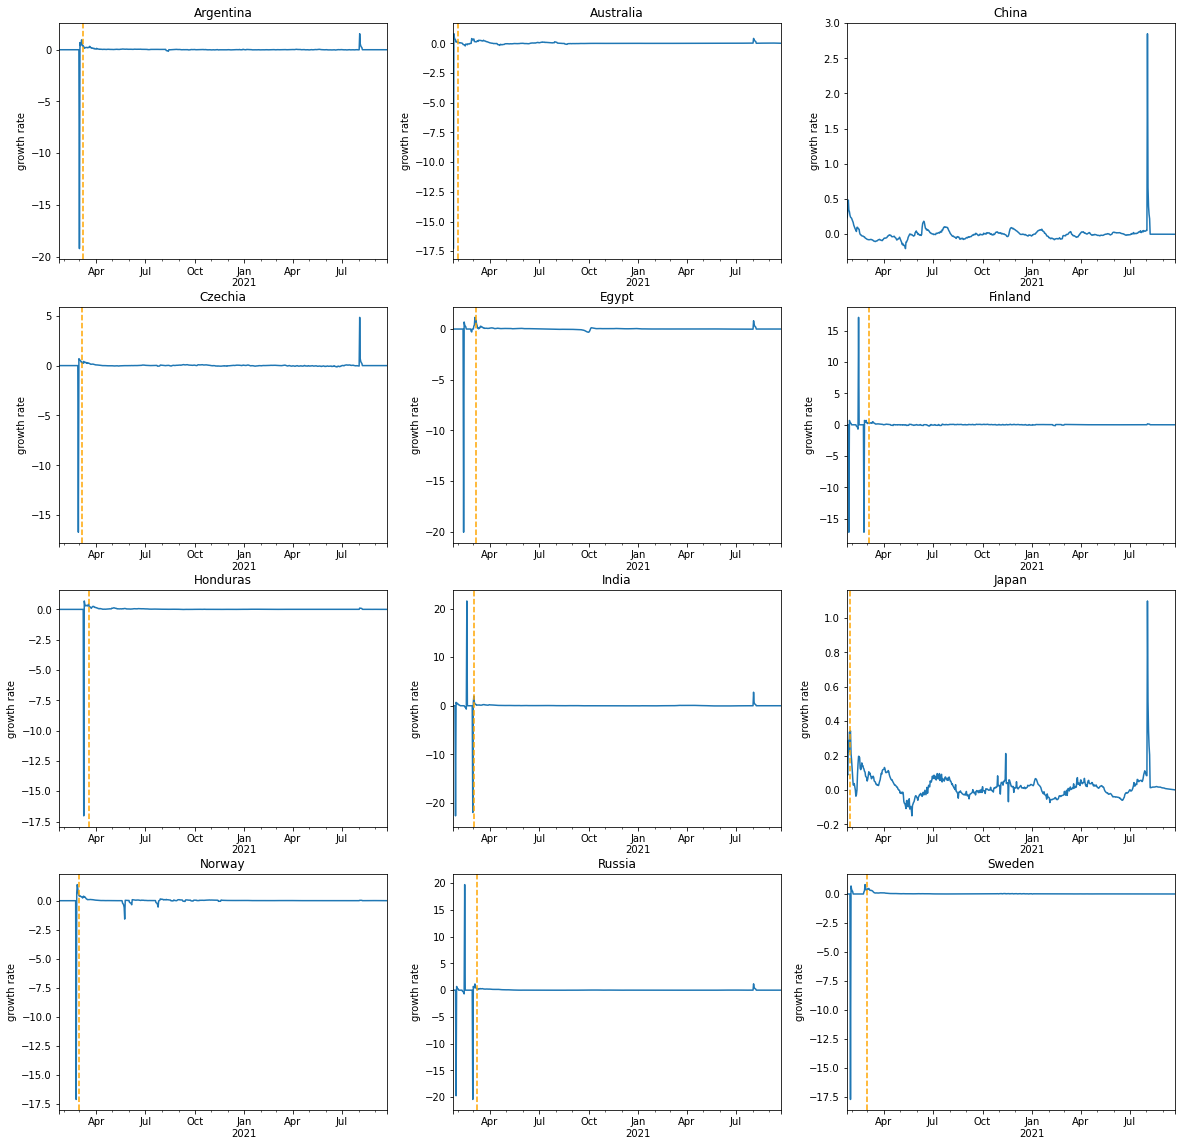

In [255]:
nrows = len(cc_dict) // 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname][cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  gr[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('growth rate')

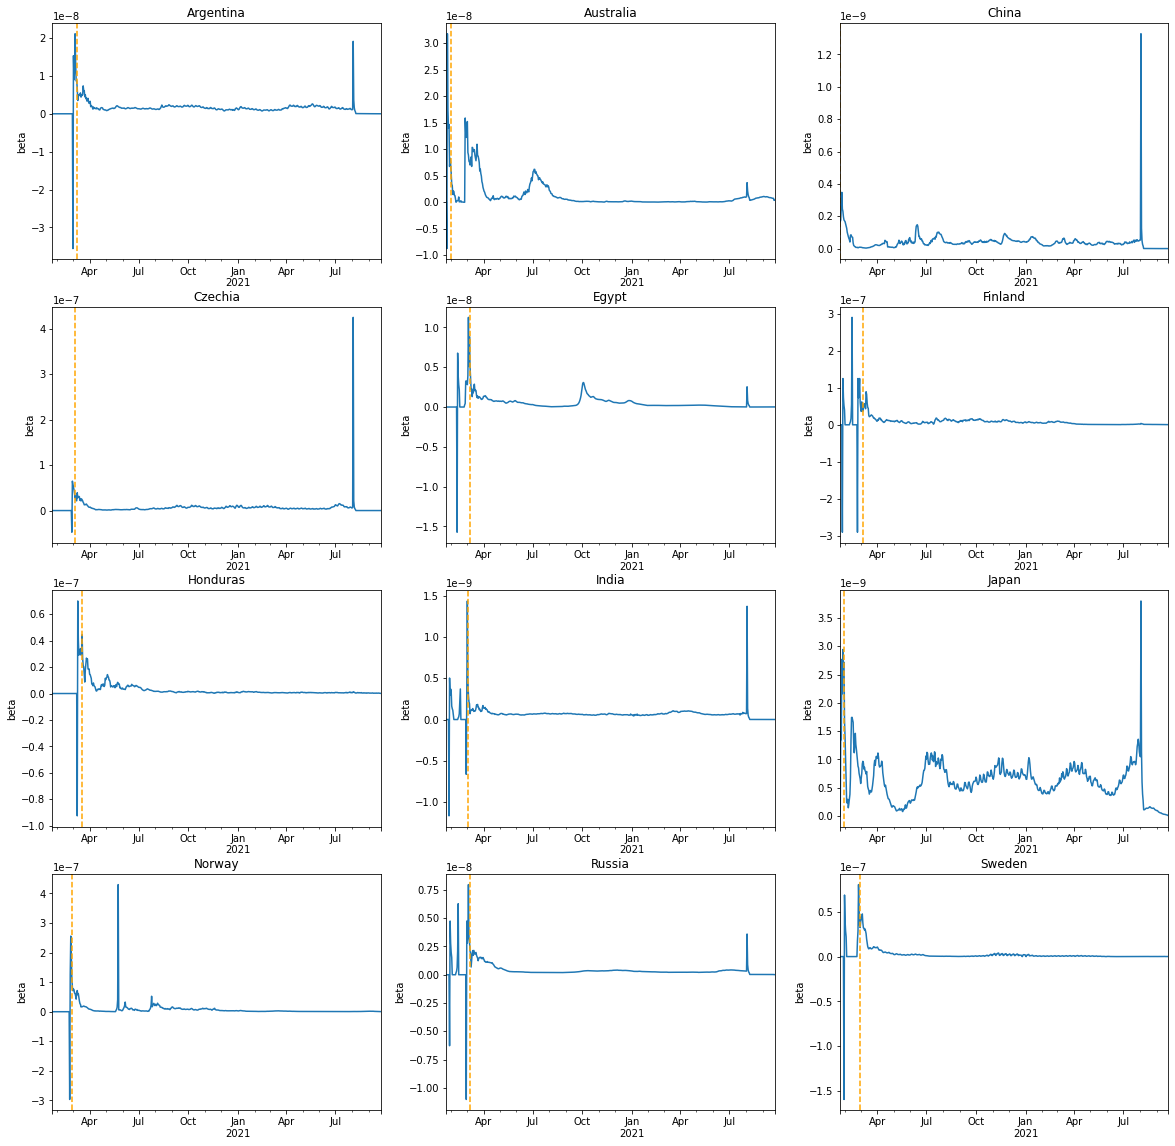

In [256]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows * ncols):
  cname = list(cc_dict.values())[i]
  first = cum_cases[cname].loc[cum_cases[cname] > 10].index.min()
  ax = axs[i // ncols, i % ncols]
  beta[cname].plot(ax=ax)
  ax.axvline(first, ls='--', color='orange')
  ax.set_title(cname)
  ax.set_ylabel('beta')

# Model

Development of the model(s) and results.

## Auxiliar

In [257]:
# aux vars
ta = gr.index.min()
tb = gr.index.max()

chx_str = [s.split('_')[0] for s in idch]

In [258]:
ta == beta.index.min()

True

In [259]:
# aux fns
def _get_init_date(iso):
  name = cc_dict[iso]
  t_idx = cum_cases.loc[cum_cases[name] > 25, name].index
  return t_idx.min()

def data_from(iso, t0, t1, tr, t_d, y):
  'Select data with location and time constraints.'

  if iso in cc_dict.keys():
    name = cc_dict[iso]
  elif iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  if not t0:
    t0 = _get_init_date(iso)
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  
  if not t1:
    if not tr:
      raise ValueError('Provide end of time range (either t1 or tr).')
    prop_case = cum_cases[name] / pop_dict[iso]
    t1 = prop_case[prop_case < tr/100].index.max()

  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

# to do: different for the two labels
def preprocess(pol_t, y_t):
  'Transform data to feed the model.'
  
  pol_t.fillna(method='pad', inplace=True) # back fill
  pol_t.fillna(value=0, inplace=True)      # if no previous value available
  pol_norm = maxabs_scale(pol_t[1:])       # match vars length at scaling
  y_norm = maxabs_scale(y_t)

  # policy combinations
  # poly = PolynomialFeatures(degree=2, interaction_only=True)
  # pol_comb = poly.fit_transform(pol_norm)
  # comb_str = poly.get_feature_names(chx_str)
  # day-of-the-week
  # day = y_t[1:].index.weekday.values.reshape(-1, 1)
  # ohe = OneHotEncoder(sparse=False).fit_transform(day)
  # ohe_str = [f'weekday {d+1}' for d in range(7)]
  # previous 
  td1 = y_norm[:-1].reshape(-1, 1)
  # group data
  arr = np.hstack([pol_norm, td1])
  col = np.append(chx_str, 'prev')
  df = pd.DataFrame(arr, columns=col)
  
  return df, y_norm[1:]

def _print_model(name, value, score):
  print('Coefficients\n------------')
  for n, v in zip(name, value):
    if v != 0:
      print('{:s} : {:3f}'.format(n, v))
  print('\nR^2\n---')
  print(round(score, 3))

## Initial model

Customized grid of values for the parameters.

Compare the linear regression and Lasso stability of coefficients.

The code is:

```
cv_flag = True
y_df = gr_smooth
cv_arr = []
grid = {'tr': [0.5, 0.75, 1, 2, 3], 'delay': [7, 10, 14, 18, 21]}
lin = LinearRegression()
# lasso = LassoLarsCV(cv=KFold(shuffle=True), max_iter=3, eps=.1**7)
# lasso = LassoCV(cv=KFold(shuffle=True), max_iter=10**5)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    cv_par = []
    X_raw, y_raw = data_from(cc, tr=par['tr'], t_d=par['delay'], y=y_df)
    X, y = preprocess(X_raw, y_raw)
    if cv_flag:
      # cross-validation
      kf = KFold(shuffle=True)
      cv_kf = []
      for train_idx, test_idx in kf.split(X):
        fit = lin.fit(X.values[train_idx], y.values[train_idx])
        kf_score = fit.score(X.values[test_idx], y.values[test_idx])
        cv_kf.append(kf_score)
        score = np.asarray(cv_kf).mean()
    else:
      # train-test
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
      score = lin.fit(X_train, y_train).score(X_test, y_test)
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr
```

The LARS implementation of Lasso is much faster and it was used for the CV loop. However, the number of regressors needs to be restricted due to convergency issues and the general accuracy obtained is lower compared to the standard *brute force* Lasso. Therefore, the LARS implementation it is not used anymore.

Using cross-validation on all available data, can yield sizeable negative values (sometimes) while performing least squares. Filter those values or assign value zero.

In [260]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      # to do: filter negative values
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([-1.77870406e+26, -5.41986180e+24,  5.14409823e-01,  5.66232405e-01,
        6.43371395e-01,  7.46169327e-01, -1.92605806e+25, -1.03916030e+25,
        5.62906313e-01,  6.48232165e-01, -4.81870467e+25, -8.80626262e+23,
        5.37397907e-01,  5.73216678e-01,  6.50895803e-01,  7.65804606e-01,
        5.39054898e-01,  5.47137452e-01,  5.76511121e-01,  6.57764773e-01,
       -1.62637805e+25,  5.47353614e-01,  5.45126223e-01,  5.84996800e-01,
       -2.77767371e+25])

In [261]:
cv_arr.mean()

-1.2242025690070775e+25

In [262]:
y_df = gr
cv_arr = []
grid = {'tr': [0.1, 0.25, 0.5, 1, 2.5], 'delay': [9, 12, 15, 18, 21]}
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in list(ParameterGrid(grid)):
    X_raw, y_raw = data_from(cc, None, None, par['tr'], par['delay'], y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.75943053, 0.5195311 , 0.52576009, 0.57015679, 0.64809891,
       0.7657257 , 0.55853974, 0.54974742, 0.56197419, 0.64346096,
       0.78569798, 0.53408559, 0.54181768, 0.57459655, 0.65689238,
       0.78472226, 0.54150756, 0.54731625, 0.58362163, 0.66104437,
       0.79198063, 0.54739584, 0.55756749, 0.59431005, 0.66397705])

In [263]:
cv_arr.mean()

0.6187583505474327

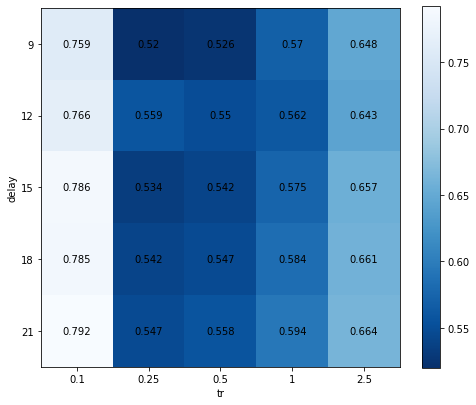

In [264]:
cv_mat = cv_arr.reshape(5, 5)
# heatmap
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(X=cv_mat, cmap='Blues_r') # 
# colorbar
ax.figure.colorbar(im, ax=ax, shrink=0.75)
# axis titles
ax.set_xlabel('tr')
ax.set_ylabel('delay')
# show all ticks...
ax.set_xticks(np.arange(len(grid['tr'])))
ax.set_yticks(np.arange(len(grid['delay'])))
# ...and label them
ax.set_xticklabels(grid['tr'])
ax.set_yticklabels(grid['delay'])
# loop over data dimensions and create text annotations
for i in range(len(grid['tr'])):
  for j in range(len(grid['delay'])):
    text = ax.text(j, i, round(cv_mat[i, j], ndigits=3), ha="center", va="center")
fig.tight_layout()
plt.show()

In [265]:
def initial_model(region, tr=.1, delay=15, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from(region, None, None, tr, delay, gr)
  X, y = preprocess(X_raw, y_raw)
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Performance ($R^2$) for the chosen parameteres. It is obtained from the training data.

In [266]:
r_sq = [initial_model(k)[3] for k in cc_dict.keys()]
np.asarray(r_sq).mean()

0.7674392011987593

In [267]:
for r_i in r_sq:
  print(round(r_i, 2))

0.88
0.93
0.56
0.84
0.76
0.76
-0.35
0.9
0.8
0.98
0.93
0.88
0.92
0.97


Textual representation of the model.

In [268]:
idx = 6 # country index
cci = list(cc_dict.keys())[idx]
initial_model(cci, print=True)

Coefficients
------------
C1 : -0.137615
C2 : -0.049723
C3 : -0.000518
C4 : 0.036226
C5 : 0.000000
C6 : 0.000000
C7 : 0.000000
C8 : -0.025936
H6 : 0.003347
prev : 0.794541

R^2
---
-0.355


In [269]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


Visual representation of the model.

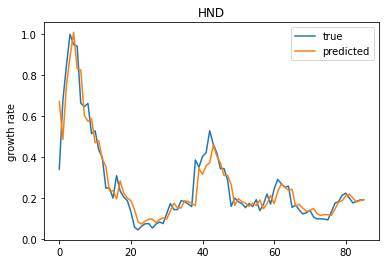

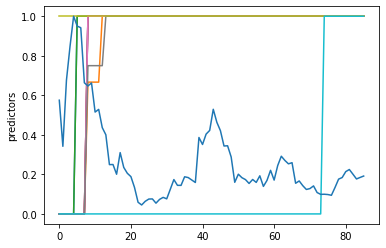


Number of data points: 86
Number of variables: 11


In [270]:
model, X, y = initial_model(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

print('\nNumber of data points:', X.shape[0])
print('Number of variables:', X.shape[1])

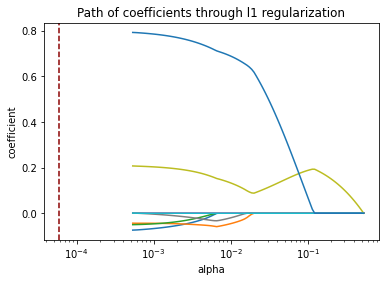

In [271]:
alphas, coefs = model.path(X, y)[:2]
alpha = model.get_params()['alpha']
for coef in coefs:
  plt.semilogx(alphas, coef)
plt.axvline(alpha, ls='--', color='darkred')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.title('Path of coefficients through l1 regularization')
plt.show()

## Transmission analysis

Parameter grid search.

In [272]:
# mm-dd-yyyy format
t_init = pd.to_datetime('06-01-2020')
t_end = t_init + pd.to_timedelta(60, unit='days')

In [273]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lin = LinearRegression()
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lin.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.75317776, 0.75416954, 0.75206614, 0.75303535, 0.75577484,
       0.75924566, 0.75826127, 0.75443162, 0.75592885, 0.75678872,
       0.75695888, 0.75536157, 0.7560172 , 0.75441484])

In [274]:
cv_arr.mean()

0.7554023017900521

In [275]:
y_df = beta
cv_arr = []
grid = range(7, 21) # delay
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for cc in cc_dict:
  cv_cc = []
  for par in grid:
    X_raw, y_raw = data_from(cc, t_init, t_end, tr=None, t_d=par, y=y_df)
    X, y = preprocess(X_raw, y_raw)
    kf = KFold(shuffle=True, random_state=rs)
    cv_kf = []
    for train_idx, test_idx in kf.split(X):
      fit = lasso.fit(X.iloc[train_idx], y[train_idx])
      kf_score = fit.score(X.iloc[test_idx], y[test_idx])
      cv_kf.append(kf_score)
      score = np.asarray(cv_kf).mean()
    cv_cc.append(score)
  cv_arr.append(cv_cc)
cv_arr = np.asarray(cv_arr).mean(axis=0) # country axis
cv_arr

array([0.74918512, 0.74848695, 0.74963883, 0.76455086, 0.76233206,
       0.76326707, 0.76458671, 0.76206718, 0.75889249, 0.74939909,
       0.75110049, 0.75745843, 0.75190839, 0.75989088])

In [276]:
cv_arr.mean()

0.7566260403572398

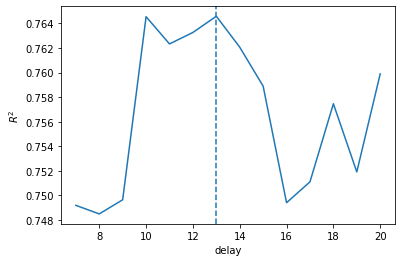

In [277]:
plt.plot(grid, cv_arr)
plt.axvline(grid[cv_arr.argmax()], ls='--')
plt.xlabel('delay')
plt.ylabel('$R^2$')
plt.show()

In [278]:
def linear_model(region, delay=12, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - delay (int) : expected time (in days) for policies to make an impact.
  - print (bool) : whether to display results via stdout.
  '''

  # divide the pandemic into subranges
  ta_i = _get_init_date(region)
  t_idx = deque(pd.date_range(start=ta_i, end=tb, freq='2M'))

  X = []; y = []; reg = []; score = []; coef_values = []
  # apply the model to each subrange
  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  for i in range(len(t_idx) - 2):
    X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, delay, beta)
    X_i, y_i = preprocess(X_raw, y_raw)
    X_train, X_test, y_train, y_test = train_test_split(
        X_i, y_i, test_size=0.2, random_state=rs
    )

    lasso.fit(X_train, y_train)
    score_i = lasso.score(X_test, y_test)

    reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
    coef_values_i = reg_i.coef_
    
    # aggregate model results
    X.append(X_i)
    y.append(y_i)
    score.append(score_i)
    reg.append(reg_i)
    coef_values.append(coef_values_i)
  
  score = np.asarray(score).mean()
  coef_values = np.asarray(coef_values).mean(axis=0)
  coef_names = X_i.columns.values

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

In [279]:
# cv_arr = []
# grid = {'tr': [0.25, 0.5, 1, 2, 5], 'delay': [9, 12, 15, 18, 21]}
# lin = LinearRegression()
# for par in list(ParameterGrid(grid)):
#   cv_par = [linear_model(k, par['tr'], par['delay'])[3] for k in cc_dict.keys()]
#   cv_arr.append(cv_par)
# cv_arr = np.asarray(cv_arr).mean(axis=1) # country axis
# cv_arr

Performance ($R^2$) for the chosen parameteres. Is computed from the training data.

In [280]:
region = list(cc_dict.keys())[12]

In [281]:
ta_i = _get_init_date(region)
t_idx = deque(pd.date_range(start=ta_i, end=tb, freq='2M'))

X = []; y = []; reg = []; score = []; coef_values = []
# apply the model to each subrange
lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
for i in range(len(t_idx) - 2):
  X_raw, y_raw = data_from(region, t_idx[i], t_idx[i + 1], None, 12, beta)
  X_i, y_i = preprocess(X_raw, y_raw)
  X_train, X_test, y_train, y_test = train_test_split(
      X_i, y_i, test_size=0.2, random_state=rs
  )

  lasso.fit(X_train, y_train)
  score_i = lasso.score(X_test, y_test)

  reg_i = Lasso(alpha=lasso.alpha_).fit(X_i, y_i)
  coef_values_i = reg_i.coef_

In [282]:
X_train

,C1,C2,C3,C4,C5,C6,C7,C8,H1,H6,prev
27,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.551938
9,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.587635
10,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.563609
13,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.701834
57,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.324163
29,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.573973
51,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.299846
17,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.844410
59,0.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.336030
42,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,0.265163


In [283]:
linear_model(list(cc_dict.keys())[12])[3]

0.6997353683853815

In [284]:
r_sq = [linear_model(k)[3] for k in cc_dict.keys()]
np.asarray(r_sq).mean()

0.6693627543664297

In [285]:
for r_i in r_sq:
  print(round(r_i, 2))

0.71
0.89
0.83
0.73
0.92
0.78
0.79
0.78
0.66
-0.72
0.94
0.45
0.7
0.91


Same summary representation as for the previous model.

In [286]:
idx = -1 # country index
cci = list(cc_dict.keys())[idx]
linear_model(cci, print=True)

Coefficients
------------
C1 : -0.003482
C2 : 0.033567
C3 : -0.006339
C4 : -0.058026
C6 : 0.000964
C7 : 0.004685
H6 : -0.015707
prev : 0.873746

R^2
---
0.907


Resulting predictions of the model.

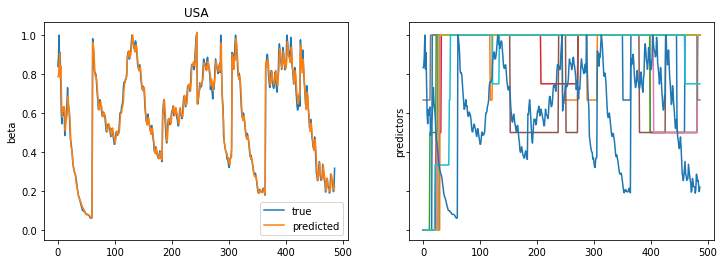

In [287]:
# to do: unify plots
models, Xs, ys = linear_model(cci)[:3]

preds = []
for model, X, y in zip(models, Xs, ys):
  pred_i = model.predict(X)
  preds.append(pred_i)

# array format
X = np.vstack(Xs)
y = np.concatenate(ys)
pred = np.concatenate(preds)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
axs[0].plot(y, label='true')
axs[0].plot(pred, label='predicted')
axs[0].set_ylabel('beta')
axs[0].set_title(cci)
axs[0].legend()
axs[1].plot(X)
axs[1].set_ylabel('predictors')
plt.show()

## Trials

Efficiency of applying weights to policy indicators in accordance to the proportion of the population who is affected by the policies.

In [288]:
tot_dict = {
    code: name for code, name in zip(
        oxcgrt_sub['CountryCode'].unique(), 
        oxcgrt_sub['CountryName'].unique()
    )
}
tot_dict['USA'] = 'US'
tot_dict

{'BRA': 'Brazil',
 'CAN': 'Canada',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'USA': 'US'}

In [289]:
sub_dict = {rc: rc.split('_')[0] for rc in oxcgrt_sub['RegionCode'].unique()}
for key in sub_dict.keys():
  # correct country codes
  sub_dict[key] = sub_dict[key].replace('BR', 'BRA')
  sub_dict[key] = sub_dict[key].replace('UK', 'GBR')
  sub_dict[key] = sub_dict[key].replace('US', 'USA')
sub_dict

{'BR_AC': 'BRA',
 'BR_AL': 'BRA',
 'BR_AM': 'BRA',
 'BR_AP': 'BRA',
 'BR_BA': 'BRA',
 'BR_CE': 'BRA',
 'BR_DF': 'BRA',
 'BR_ES': 'BRA',
 'BR_GO': 'BRA',
 'BR_MA': 'BRA',
 'BR_MG': 'BRA',
 'BR_MS': 'BRA',
 'BR_MT': 'BRA',
 'BR_PA': 'BRA',
 'BR_PB': 'BRA',
 'BR_PE': 'BRA',
 'BR_PI': 'BRA',
 'BR_PR': 'BRA',
 'BR_RJ': 'BRA',
 'BR_RN': 'BRA',
 'BR_RO': 'BRA',
 'BR_RR': 'BRA',
 'BR_RS': 'BRA',
 'BR_SC': 'BRA',
 'BR_SE': 'BRA',
 'BR_SP': 'BRA',
 'BR_TO': 'BRA',
 'CAN_AB': 'CAN',
 'CAN_BC': 'CAN',
 'CAN_MB': 'CAN',
 'CAN_NB': 'CAN',
 'CAN_NL': 'CAN',
 'CAN_NS': 'CAN',
 'CAN_NT': 'CAN',
 'CAN_NU': 'CAN',
 'CAN_ON': 'CAN',
 'CAN_PE': 'CAN',
 'CAN_QC': 'CAN',
 'CAN_SK': 'CAN',
 'CAN_YT': 'CAN',
 'CHN_AH': 'CHN',
 'CHN_BJ': 'CHN',
 'CHN_CQ': 'CHN',
 'CHN_FJ': 'CHN',
 'CHN_GD': 'CHN',
 'CHN_GS': 'CHN',
 'CHN_GX': 'CHN',
 'CHN_GZ': 'CHN',
 'CHN_HA': 'CHN',
 'CHN_HB': 'CHN',
 'CHN_HE': 'CHN',
 'CHN_HI': 'CHN',
 'CHN_HL': 'CHN',
 'CHN_HN': 'CHN',
 'CHN_JL': 'CHN',
 'CHN_JS': 'CHN',
 'CHN_JX': 'CHN',
 

In [290]:
for code, name in zip(oxcgrt_sub['RegionCode'].unique(), oxcgrt_sub['RegionName'].unique()):
  print(code, '<->', name)

BR_AC <-> Acre
BR_AL <-> Alagoas
BR_AM <-> Amazonas
BR_AP <-> Amapa
BR_BA <-> Bahia
BR_CE <-> Ceara
BR_DF <-> Distrito Federal
BR_ES <-> Espirito Santo
BR_GO <-> Goias
BR_MA <-> Maranhao
BR_MG <-> Minas Gerais
BR_MS <-> Mato Grosso do Sul
BR_MT <-> Mato Grosso
BR_PA <-> Para
BR_PB <-> Paraiba
BR_PE <-> Pernambuco
BR_PI <-> Piaui
BR_PR <-> Parana
BR_RJ <-> Rio de Janeiro
BR_RN <-> Rio Grande do Norte
BR_RO <-> Rondonia
BR_RR <-> Roraima
BR_RS <-> Rio Grande do Sul
BR_SC <-> Santa Catarina
BR_SE <-> Sergipe
BR_SP <-> Sao Paulo
BR_TO <-> Tocantins
CAN_AB <-> Alberta
CAN_BC <-> British Columbia
CAN_MB <-> Manitoba
CAN_NB <-> New Brunswick
CAN_NL <-> Newfoundland and Labrador
CAN_NS <-> Nova Scotia
CAN_NT <-> Northwest Territories
CAN_NU <-> Nunavut
CAN_ON <-> Ontario
CAN_PE <-> Prince Edward Island
CAN_QC <-> Quebec
CAN_SK <-> Saskatchewan
CAN_YT <-> Yukon
CHN_AH <-> Anhui
CHN_BJ <-> Beijing
CHN_CQ <-> Chongqing
CHN_FJ <-> Fujian
CHN_GD <-> Guangdong
CHN_GS <-> Gansu
CHN_GX <-> Guangxi
CHN

In [291]:
# https://worldpopulationreview.com/countries
tot_pop = {
    'BRA': 212559417,
    'CAN': 37742154,
    'CHN': 1439323776,
    'GBR': 67886011,
    'USA': 331002651
}

# https://en.wikipedia.org/wiki/List_of_Brazilian_states_by_population
# https://worldpopulationreview.com/canadian-provinces
# https://en.wikipedia.org/wiki/List_of_Chinese_administrative_divisions_by_population
# https://en.wikipedia.org/wiki/Countries_of_the_United_Kingdom_by_population (2019)
# https://worldpopulationreview.com/states (2021)
sub_pop = {
    'BR_AC': 894470, 'BR_AL': 3351543, 'BR_AM': 4207714,
    'BR_AP': 861773, 'BR_BA': 14930634, 'BR_CE': 9187103,
    'BR_DF': 3055149, 'BR_ES': 4064052, 'BR_GO': 7113540,
    'BR_MA': 7114598, 'BR_MG': 21292666, 'BR_MS': 2809394,
    'BR_MT': 3526220, 'BR_PA': 8690745, 'BR_PB': 4039277,
    'BR_PE': 9616621, 'BR_PI': 3281480, 'BR_PR': 11516840,
    'BR_RJ': 17366189, 'BR_RN': 3534165, 'BR_RO': 1796460,
    'BR_RR': 631181, 'BR_RS': 11422973, 'BR_SC': 7252502,
    'BR_SE': 2318822, 'BR_SP': 46289333, 'BR_TO': 1590248,
    'CAN_AB': 4428112, 'CAN_BC': 5145851, 'CAN_MB': 1379584,
    'CAN_NB': 781315, 'CAN_NL': 520998, 'CAN_NS': 979115,
    'CAN_NT': 45074, 'CAN_NU': 39285, 'CAN_ON': 14733119,
    'CAN_PE': 159713, 'CAN_QC': 8575779, 'CAN_SK': 1177884,
    'CAN_YT': 42176, 'CHN_AH': 61027171, 'CHN_BJ': 21893095,
    'CHN_CQ': 32054159, 'CHN_FJ': 41540086, 'CHN_GD': 126012510,
    'CHN_GS': 25019831, 'CHN_GX': 50126804, 'CHN_GZ': 38562148,
    'CHN_HA': 99365519, 'CHN_HB': 57752557, 'CHN_HE': 74610235,
    'CHN_HI': 10081232, 'CHN_HL': 31850088, 'CHN_HN': 66444864,
    'CHN_JL': 24073453, 'CHN_JS': 84748016, 'CHN_JX': 45188635,
    'CHN_LN': 42591407, 'CHN_NM': 24049155, 'CHN_NX': 7202654,
    'CHN_QH': 5923957, 'CHN_SC': 83674866, 'CHN_SD': 101527453,
    'CHN_SH': 24870895, 'CHN_SN': 39528999, 'CHN_SX': 34915616,
    'CHN_TJ': 13866009, 'CHN_XJ': 25852345, 'CHN_XZ': 3648100,
    'CHN_YN': 47209277, 'CHN_ZJ': 64567588, 'UK_ENG': 56286961,
    'UK_NIR': 1893667, 'UK_SCO': 5463300, 'UK_WAL': 3152879	,
    'US_AK': 724357, 'US_AL': 4934193, 'US_AR': 3033946,
    'US_AZ': 7520103, 'US_CA': 39613493, 'US_CO': 5893634,
    'US_CT': 3552821, 'US_DC': 714153, 'US_DE': 990334,
    'US_FL': 21944577, 'US_GA': 10830007, 'US_HI': 1406430,
    'US_IA': 3167974, 'US_ID': 1860123, 'US_IL': 12569321,
    'US_IN': 6805663, 'US_KS': 2917224, 'US_KY': 4480713,
    'US_LA': 4627002, 'US_MA': 6912239, 'US_MD': 6065436,
    'US_ME': 1354522, 'US_MI': 9992427, 'US_MN': 5706398,
    'US_MO': 6169038, 'US_MS': 2966407, 'US_MT': 1085004,
    'US_NC': 10701022, 'US_ND': 770026, 'US_NE': 1951996,
    'US_NH': 1372203, 'US_NJ': 8874520, 'US_NM': 2105005,
    'US_NV': 3185786, 'US_NY': 19299981, 'US_OH': 11714618,
    'US_OK': 3990443, 'US_OR': 4289439, 'US_PA': 12804123,
    'US_RI': 1061509, 'US_SC': 5277830, 'US_SD': 896581,
    'US_TN': 6944260, 'US_TX': 29730311, 'US_UT': 3310774,
    'US_VA': 8603985, 'US_VT': 623251, 'US_WA': 7796941,
    'US_WI': 5852490, 'US_WV': 1767859, 'US_WY': 581075
}

In [292]:
sub_prop = {rc: sub_pop[rc] / tot_pop[cc] for rc, cc in sub_dict.items()}
sub_prop

{'BR_AC': 0.004208093965556934,
 'BR_AL': 0.015767558301121986,
 'BR_AM': 0.01979547205852564,
 'BR_AP': 0.004054268741243302,
 'BR_BA': 0.07024216668791484,
 'BR_CE': 0.043221340788679334,
 'BR_DF': 0.014373152895879461,
 'BR_ES': 0.019119604566849184,
 'BR_GO': 0.0334661249094412,
 'BR_MA': 0.03347110234123384,
 'BR_MG': 0.10017277192663734,
 'BR_MS': 0.013216982054481265,
 'BR_MT': 0.016589337935566505,
 'BR_PA': 0.04088619136549476,
 'BR_PB': 0.01900304892161047,
 'BR_PE': 0.04524203695948225,
 'BR_PI': 0.01543794222958374,
 'BR_PR': 0.05418174439196923,
 'BR_RJ': 0.08170039815267277,
 'BR_RN': 0.016626715719680395,
 'BR_RO': 0.008451566274290261,
 'BR_RR': 0.002969433247928037,
 'BR_RS': 0.053740140809663585,
 'BR_SC': 0.034119880936632416,
 'BR_SE': 0.010909053255448099,
 'BR_SP': 0.21777126439897979,
 'BR_TO': 0.007481428122283569,
 'CAN_AB': 0.1173253651606636,
 'CAN_BC': 0.13634227129696944,
 'CAN_MB': 0.036552868710143044,
 'CAN_NB': 0.020701388691276072,
 'CAN_NL': 0.0138041

In [293]:
# REPEAT COMPUTATION OF LABELS
cum_cases_alt = jhu_cases[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths_alt = jhu_death[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries_alt = jhu_recov[tot_dict.values()].rolling(window, min_periods=1, center=True).mean()

R_alt = cum_deaths_alt + cum_recoveries_alt
I_alt = cum_cases_alt - R_alt
S_alt = tot_pop.values() - cum_cases_alt

i_prop_alt = I_alt / tot_pop.values()
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i_alt = np.log(i_prop_alt)
warnings.resetwarnings()
log_i_alt[np.isinf(log_i_alt)] = 0 # before the pandemic begins, the growth must be zero
gr_alt = log_i_alt[1:] - log_i_alt[:-1].values # different index
gr_alt

Country/Region,Brazil,Canada,China,United Kingdom,US
2020-01-23,0.000000,0.000000,0.229565,0.000000,0.117783
2020-01-24,0.000000,-19.055726,0.247127,0.000000,0.382992
2020-01-25,0.000000,0.693147,0.354482,0.000000,0.310155
2020-01-26,0.000000,0.693147,0.485826,0.000000,0.236389
2020-01-27,0.000000,0.405465,0.342863,0.000000,0.191055
...,...,...,...,...,...
2021-09-19,0.001708,0.002738,0.000565,0.005363,0.002976
2021-09-20,0.001944,0.002603,0.000555,0.005306,0.002605
2021-09-21,0.000730,0.002947,0.000525,0.005460,0.002932
2021-09-22,0.000297,0.001895,0.000280,0.002619,0.001842


Steps to apply the weights;
1. Pivot the original df and construct multilevel columns with region and country.
2. Convert to boolean type to obtain a binary representation.
3. Multiply by the proportional population
4. Stack the region column and group by date, which is equivalent to sum up the proportion of each region.

In [294]:
C1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[0])
C2_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[1])
C3_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[2])
C4_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[3])
C5_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[4])
C6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[5])
C7_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[6])
C8_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[7])
H1_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[8])
H6_sub = oxcgrt_sub.pivot(index='Date', columns=['CountryCode', 'RegionCode'], values=idch[9])

C1_bin = C1_sub.astype(bool) * sub_prop.values()
C2_bin = C2_sub.astype(bool) * sub_prop.values()
C3_bin = C3_sub.astype(bool) * sub_prop.values()
C4_bin = C4_sub.astype(bool) * sub_prop.values()
C5_bin = C5_sub.astype(bool) * sub_prop.values()
C6_bin = C6_sub.astype(bool) * sub_prop.values()
C7_bin = C7_sub.astype(bool) * sub_prop.values()
C8_bin = C8_sub.astype(bool) * sub_prop.values()
H1_bin = H1_sub.astype(bool) * sub_prop.values()
H6_bin = H6_sub.astype(bool) * sub_prop.values()

C1_weights = C1_bin.stack().groupby('Date').sum()
C2_weights = C2_bin.stack().groupby('Date').sum()
C3_weights = C3_bin.stack().groupby('Date').sum()
C4_weights = C4_bin.stack().groupby('Date').sum()
C5_weights = C5_bin.stack().groupby('Date').sum()
C6_weights = C6_bin.stack().groupby('Date').sum()
C7_weights = C7_bin.stack().groupby('Date').sum()
C8_weights = C8_bin.stack().groupby('Date').sum()
H1_weights = H1_bin.stack().groupby('Date').sum()
H6_weights = H6_bin.stack().groupby('Date').sum()

CH_w = [
        C1_weights, C2_weights, C3_weights, C4_weights, C5_weights,
        C6_weights, C7_weights, C8_weights, H1_weights, H6_weights
]

Comparison between the fits with and without applying weights.

In [295]:
def data_from_alt(iso, tr, t_d, y, weight):
  'Select data with location and time constraints.'

  if iso in tot_dict.keys():
    name = tot_dict[iso]
  else:
    raise NameError('Invalid ISO code.')
  
  t0 = cum_cases_alt.loc[cum_cases_alt[name] > 25, name].index.min()
  if t0 < ta:
    t0 = ta # previous value NA otherwise
  prop_case = cum_cases_alt[name] / tot_pop[iso]
  t1 = prop_case[prop_case < tr/100].index.max()
  
  delay = pd.to_timedelta(t_d, unit='days')
  ch_x = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_X]
  pol_t = pd.concat(ch_x, axis=1, ignore_index=True)
  if weight:
    # apply policy weights
    ch_w = [ch.loc[t0 - delay:t1 - delay, iso] for ch in CH_w]
    w_t = pd.concat(ch_w, axis=1, ignore_index=True)
    pol_t *= w_t
  
  y_t = y.loc[t0:t1, name]
  
  return pol_t, y_t

In [296]:
def initial_model_weighted(region, tr=1, delay=12, weighted=True, print=False):
  '''Policy effect on cases based on linear model.

  Parameters
  ----------
  - region (str) : country ISO code.
  - tr (float) : percentage (%) treshold for applying the approximation.
  - delay (int) : expected time (in days) for policies to make an impact.
  - weighted (bool) : wheter to apply weights to the policies.
  - print (bool) : whether to display results via stdout.
  '''

  X_raw, y_raw = data_from_alt(region, tr, delay, gr_alt, weighted)
  X, y = preprocess(X_raw, y_raw) 
  coef_names = X.columns.values
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=rs
  )

  lasso = LassoCV(cv=KFold(shuffle=True, random_state=rs), max_iter=10**4)
  lasso.fit(X_train, y_train)
  score = lasso.score(X_test, y_test)

  reg = Lasso(alpha=lasso.alpha_).fit(X, y)
  coef_values = reg.coef_

  if print:
    _print_model(coef_names, coef_values, score)
  else:
    return reg, X, y, score

Don't apply weights

In [297]:
r_sq = [initial_model_weighted(k, weighted=False)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.49756217860198915

In [298]:
idx = 1 # country index
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, weighted=False, print=True)

Coefficients
------------
C1 : -0.038754
C3 : -0.000246
C4 : -0.035433
C7 : -0.070914
H1 : -0.000628
prev : 0.431466

R^2
---
0.935


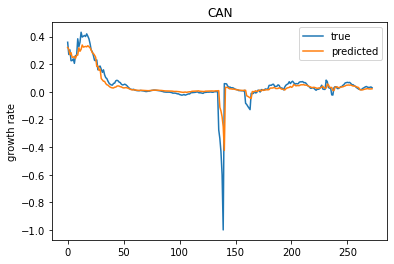

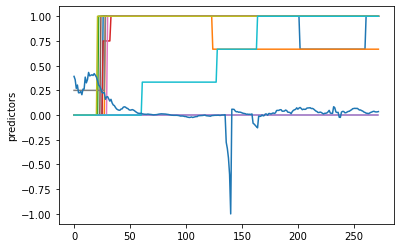

In [299]:
model, X, y = initial_model_weighted(cci, weighted=False)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()

Apply weights

In [300]:
r_sq = [initial_model_weighted(k, weighted=True)[3] for k in tot_dict.keys()]
np.asarray(r_sq).mean()

0.5070393826451769

In [301]:
cci = list(tot_dict.keys())[idx]
initial_model_weighted(cci, print=True)

Coefficients
------------
C1 : -0.031558
C4 : -0.110632
prev : 0.448955

R^2
---
0.933


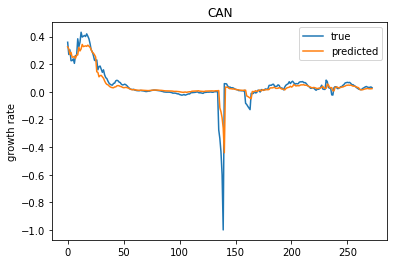

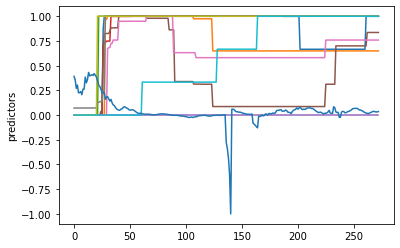

In [302]:
model, X, y = initial_model_weighted(cci)[:3]

plt.plot(y, label='true')
plt.plot(model.predict(X), label='predicted')
plt.ylabel('growth rate')
plt.title(cci)
plt.legend()
X.plot(legend=False)
plt.ylabel('predictors')
plt.show()